## https://blog.csdn.net/SZU_Hadooper/article/details/79050483
## https://flashgene.com/archives/140094.html
## https://medium.com/@gary1346aa/%E6%A9%9F%E6%A2%B0%E5%AD%B8%E7%BF%92-gradient-boosting-1-272e8d7b17e1

## 資料分析&機器學習 第5.2講: Kaggle機器學習競賽神器XGBoost介紹
https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC5-2%E8%AC%9B-kaggle%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E7%AB%B6%E8%B3%BD%E7%A5%9E%E5%99%A8xgboost%E4%BB%8B%E7%B4%B9-1c8f55cffcc

## https://read01.com/7DB44zB.html#.YEYOJWgzaHs

In [346]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import re
import sweetviz as sv
save_model = './NN/training_model2.h5'
save_modelxg = './GX/training_model2.model'



In [347]:
def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df

# Def :missData  查看缺失情况

In [348]:
def missData(df_train):
    
    X_missing = df_train#.drop(['survived'],axis=1)

    # 查看缺失情况
    missing = X_missing.isna().sum()
    missing = pd.DataFrame(data={'特徵': missing.index,'缺失值個數':missing.values})
    #通过~取反，选取不包含数字0的行
    missing = missing[~missing['缺失值個數'].isin([0])]
    # 缺失比例
    missing['缺失比率'] =  missing['缺失值個數']/X_missing.shape[0]
    print(missing)
    # 排序
    missing.sort_values(by='缺失比率',ascending=False)

    #柱形图可视化
    # import matplotlib.pyplot as plt
    # import numpy as np
    import pylab as pl
    fig = plt.figure()#figsize=(18,6))
    plt.bar(np.arange(missing.shape[0]), list(missing['缺失比率'].values), align = 'center',color=['red','green','yellow','steelblue'])
    plt.title('Histogram of missing value of variables')
    plt.xlabel('variables names')
    plt.ylabel('missing rate')
    # 添加x轴标签，并旋转90度
    #plt.xticks(np.arange(missing.shape[0]),list(missing['特征']))
    plt.xticks(rotation=90)
    # 添加数值显示
    # for x,y in enumerate(list(missing['缺失比例'].values)):
    #     plt.text(x,y*-0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
        
    #     plt.xticks(rotation=90)
    # 添加数值显示
    # for x,y in enumerate(list(missing['缺失比例'].values)):
    #     plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
    #plt.ylim([0,1.2])
    plt.show()

In [349]:
#def handleData(df):
   # df = readDataFromFile(source_file_path)

    # df['PRIORITY'] = df['PRIORITY'].astype(str)
    # df['IS_MAIN_ROUTE'] = df['IS_MAIN_ROUTE'].astype(str)

    # df['DATA_DATE'] = df['DATA_DATE'].astype(str)
    # df = df.loc[df['LOT_TYPE']=='FDY']
    # df = df.loc[df['LAYER']!='XX']

    # # df.fillna(0, inplace=True)
    # df = df.assign(PROCESSED_DAYS = ((pd.to_datetime(df['DATA_DATE'], format='%Y%m%d')-pd.to_datetime(df['WS_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))
    # df = df.assign(REMAIN_DAYS = ((pd.to_datetime(df['ACTUAL_WP_OUT'], format='%Y%m%d')-pd.to_datetime(df['DATA_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))

    # df2 = df.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','LAYER','LOT_ID'])

    # labelencoder = LabelEncoder()
    # df2['PRIORITY'] = labelencoder.fit_transform(df2['PRIORITY'])
    # df2['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df2['IS_MAIN_ROUTE'])
    # df2['STATUS'] = labelencoder.fit_transform(df2['STATUS'])
    # df2['CHIPNAME'] = labelencoder.fit_transform(df2['CHIPNAME'])

    # df3 = df2.drop(df2.loc[:, '0I':'UG'].columns, axis = 1) 
    # # df3.info()

# Def EDA 繪製 EDA 圖

In [350]:
def EDA(df_train,targetfeat='NO_HOLD_QTY'):
    
    pairwise_analysis='off' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
    report_train = sv.analyze([df_train, 'train'],
                                    target_feat= targetfeat
    )
    report_train.show_html(filepath='./sweetvizHTML/HW2_train_report.html' ) # 儲存為html的格式

    # compare_subsets_report = sv.compare_intra(df_train,
    #                                         df_train['Finish']==1, # 給條件區分
    #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
    #                                         target_feat='NO_HOLD_QTY',
    #                                         )

    # compare_subsets_report.show_html(filepath='./sweetvizHTML/HW2_Compare_report.html')

# Def: preHandleDat() :資料整理(label encoding one hot encoding 特徵縮放)

In [351]:
def preHandleDat(df):
   # num_cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
    num_cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS', 'C_AI']
 
    df = df.drop('WIP_QTY', axis=1)

    df = df.sort_values('NO_HOLD_QTY')
    print(df.describe())        
#      2   WIP_QTY      120018 non-null  float64
#  3   NO_HOLD_QTY  120018 non-null  float64
#  4   MOVE_QTY     120018 non-null  float64
#  5   M            118540 non-null  float64
#  6   U            118442 non-null  float64
#  7   PT           120018 non-null  float64
#  8   UP_TIME      118540 non-null  float64
#  9   EQP_UTIL     118540 non-null  float64
#  10  TC           115972 non-null  float64
#  11  CS           115972 non-null  float64
#  12  AI           113521 non-null  float64
#  13  C_AI         112975 non-null  float64
    
    #  8   Finish           3898 non-null   object 
    #  9   WEEKDAY          3898 non-null   object 
    #  11  ToolPrefix       3898 non-null   object 
    #  12  ToolSub          3818 non-null   object 
    #  13  ToolPrefix_NEXT  3898 non-null   object 
    #  14  ToolSub_NEXT     3806 non-null   object  
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import RobustScaler

    # std_scaler = StandardScaler()
    # std_scaler.fit(df_train[num_cols])
    # df_train_scal = df
    # df_train_scal[num_cols]= std_scaler.transform(df_train[num_cols])
    # df_train_scal 

    minMax_scaler = MinMaxScaler()
    minMax_scaler.fit(df_train[num_cols])
    df_train_scal = df
    df_train_scal[num_cols]= minMax_scaler.transform(df[num_cols])


    # robust_scaler = RobustScaler()
    # robust_scaler.fit(df_train[num_cols])
    # df_train_scal = df
    # df_train_scal[num_cols] = robust_scaler.transform(df[num_cols])
    #==================================================
    #==================================================
    #one hot encoder
    #==================================================
    #cat_cols = ['Finish','WEEKDAY','ToolPrefix','ToolSub','ToolPrefix_NEXT','ToolSub_NEXT','TOOLG_ID']
    #cat_cols = [ 'ToolPrefix','ToolSub','TOOLG_ID']
    cat_cols = [ 'TOOLG_ID']
    df_train_eh =pd.get_dummies(df_train_scal.drop('MOVE_QTY', axis=1),columns=cat_cols)
    # df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
    #df_test_eh = df_test_eh.reindex(columns = df_test_eh.columns, fill_value=0)
   


    # #rescaling 特徵縮放(0~1) 特徵最小/全距
    # # minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))  
    # # X_dropped = minmax_scale.fit_transform(X_dropped)  
     
    # from sklearn.preprocessing import StandardScaler

    # # scaler = StandardScaler().fit(X)
    # # X_dropped = scaler.transform(X_dropped)
    # # Scaling features
    # std_scaler = StandardScaler()
    # df_test_eh = std_scaler.fit_transform(df_test_eh)
    #print(df_train_eh.head())
    # return df_train_ehNO_HOLD_QTY'].max()* .75

    #np.asarray(x).astype('float32')        
           
    X_dropped = np.asarray(df_train_eh)
    Y_dropped = np.asarray(df['MOVE_QTY'])
    return X_dropped,Y_dropped
    

# def trainModel() 訓練模型

In [352]:
# #root_mean_squared_error---------------------------------
from tensorflow.keras import backend as K 
def root_mean_squared_error(y_true, y_pred): 
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

## xgboost
> conda install -c conda-forge xgboost


In [353]:
# import xgboost as xgb
# from sklearn.metrics import log_loss
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(df_train)
# X_dropped,Y_dropped = preHandleDat(train)
# dtrain =xgb.DMatrix(X_dropped, Y_dropped)
# # param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
# param = {'max_depth':6, 'eta':1, #this is the default value anyway 
#     'colsample_bytree':1 #this is the default value anyway 
# }


# num_round = 2
# bst = xgb.train(param, dtrain, num_round)

In [400]:
def trainModelXG(toolG_Id,df,save_model): 
    save_model_tool = getSavePath(toolG_Id,save_model)    
   
    X_dropped,Y_dropped = preHandleDat(df)
    import xgboost as xgb
    from sklearn.metrics import log_loss
    from sklearn.model_selection import train_test_split
    # 做数据切分
    train, test = train_test_split(df)
    X_dropped,Y_dropped = preHandleDat(train)
    X_droppedtest,Y_droppedtest = preHandleDat(test)
    # read in data
    # # 转换成Dmatrix格式
    # feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    # target_column = 'Outcome'
    # # 取出numpy array去初始化DMatrix对象
    # xgtrain = xgb.DMatrix(train[feature_columns].values, train[target_column].values)
    # xgtest = xgb.DMatrix(test[feature_columns].values, test[target_column].values)

    xgtrain = xgb.DMatrix(X_dropped, Y_dropped)
    xgtest = xgb.DMatrix(X_droppedtest, Y_droppedtest)
    
    # # specify parameters via map
    # param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
    # num_round = 2
    # bst = xgb.train(param, df, num_round)


        #参数设定
    '''
    max_depth:用于设置树的最大深度,默认为6，范围为：》1
    eta:可以看作为学习率
    为了防止过拟合，更新过程中用到的收缩步长，
    再每次提升计算之后算法会直接获得新特征的权重。eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3
    取值范围为：[0,1]
    silent：0表示输出信息， 1表示安静模式
    subsample:表示观测的子样本的比率，将其设置未0.5以为着xgboost将随机抽取一半观测用于数的生长，这将有助于防止过拟合现象，范围未（0，1]
    colsample_bytree:表示用于构造每棵树时变量的子样本比率,range: (0,1]
    objective：这个参数定义需要被最小化的损失函数。
    binary:logistic：二分类的逻辑回归，返回预测的概率
    '''
    # param = {'max_depth':5, 'eta':0.1, 'silent':1, 'subsample':0.7, 'colsample_bytree':0.7, 'objective':'binary:logistic' }
    # param = {'max_depth':6, 'eta':1, #this is the default value anyway 
    # 'colsample_bytree':1 #this is the default value anyway 
    # }
    params ={'learning_rate': 0.1,
              'max_depth': 10,                # 构建树的深度，越大越容易过拟合
              'num_boost_round':2000,
              'objective':'reg:squarederror',  # 线性回归问题
              #'objective': 'reg:linear',      # 线性回归问题，早期版本的参与，将被reg:squarederror替换
              'random_state': 7,
              'gamma':0,
              'subsample':0.8,
              'colsample_bytree':0.8,
              'reg_alpha':0.005,
              'n_estimators' : 1000,
              'eval_metric':['logloss','rmse','mae'],   #分类有“auc”
              'eta':0.3  #为了防止过拟合，更新过程中用到的收缩步长。eta通过缩减特征 的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1]
            }

    num_round = 10
    best_nround = 1000
    
    # bst = xgb.train(param, dtrain, num_round)
    # 设定watchlist用于查看模型状态
    watchlist  = [(xgtest,'eval'), (xgtrain,'train')]
    
    # res = xgb.cv(params,dtrain,num_boost_round=5000,metrics='rmse',early_stopping_rounds=25)
    # #找到最佳迭代轮数
    # best_nround = res.shape[0] - 1


    bst = xgb.train(params, xgtrain, best_nround, watchlist)

    # 使用模型预测
    preds = bst.predict(xgtest)

    # 判断准确率
    labels = xgtest.get_label()
    print('错误类为%f' % \
        (sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))

    #模型存储
    bst.save_model(save_model_tool)
    # make prediction
    #preds = bst.predict(dtest)

    # mod = xgb.XGBRegressor(
    #     gamma=1,                 
    #     learning_rate=0.01,
    #     max_depth=3,
    #     n_estimators=10000,                                                                    
    #     subsample=0.8,
    #     random_state=34
    # ) 

    # mod.fit(X_train, y_train)
    # predictions = mod.predict(X_val)
    # rmse = sqrt(mean_squared_error(y_val, predictions))
    # print("score: {0:,.0f}".format(rmse))

In [355]:
def trainModel(toolG_Id,df,save_model):

    #save_model_tool = getSavePath(df['TOOLG_ID'].iloc[0],save_model)    
    save_model_tool = getSavePath(toolG_Id,save_model)    
    # cleanString = re.sub('\W+','', df['TOOLG_ID'].iloc[0] )
    # print(cleanString)
    
    # save_model=save_model = './training_model2'+cleanString+'.h5'
 
    #======================================================================================
    # print(df.head(2))
    # df_train_eh = preHandleDat(df)
    # X_dropped = np.asarray(df_train_eh)
    # Y_dropped = np.asarray(df['MOVE_QTY'])
    X_dropped,Y_dropped = preHandleDat(df)
    #print("Y_dropped",Y_dropped)
        # print(X_dropped)
            # print(Y_dropped)
            
                #1.建立模型(Model)
                    #將Layer放入Model中)
    # print(X_dropped)
    # print(Y_dropped)

    #1.建立模型(Model)
    #將Layer放入Model中
    # Activation Functions
    # A.softmax：值介於 [0,1] 之間，且機率總和等於 1，適合多分類使用。
    # B.sigmoid：值介於 [0,1] 之間，且分布兩極化，大部分不是 0，就是 1，適合二分法。
    # C.Relu (Rectified Linear Units)：忽略負值，介於 [0,∞] 之間。
    # D.tanh：與sigmoid類似，但值介於[-1,1]之間，即傳導有負值。
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]), # units：输出维度
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dense(units=64),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=1)

        
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),

        #tf.keras.layers.Dense(units=1)
        tf.keras.layers.Dense(units=1, kernel_initializer='random_uniform',activation='relu')
        

        ])
    #model.summary()
    #======================================================================================
    # 定義 tensorboard callback
    tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/AI/POC/homework/logs2')]
    #======================================================================================
    #2. 確立目標及求解方法：以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。

    #compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
    
    # # model.compile( loss = root_mean_squared_error,optimizer = "rmsprop",metrics =["accuracy"],callbacks=tensorboard_callback) 
    # model.compile(loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
    # 
    #--------------------------
    #[Keras 損失函數(loss)]
    #   A.均方誤差(mean_squared_error)----mean_squared_error-------------------------------
    #   B.Hinge Error (hinge)：是一種單邊誤差，不考慮負值，適用於『支援向量機』(SVM)的最大間隔分類法(maximum-margin classification)
     #  C.Cross Entropy (categorical_crossentropy)：當預測值與實際值愈相近，損失函數就愈小，反之差距很大，就會更影響損失函數的值，這篇文章 主張要用 Cross Entropy 取代 MSE，因為，在梯度下時，Cross Entropy 計算速度較快，其他變形包括 sparse_categorical_crossentropy、binary_crossentropy。
     #  D.其他還有 logcosh、kullback_leibler_divergence、poisson、cosine_proximity 等。
    #--------------------------
    #[優化函數(Optimizer)]
    #   A. 隨機梯度下降法(Stochastic Gradient Descent, SGD)：就是利用偏微分，逐步按著下降的方向，尋找最佳解。它含以下參數：
    #        Learning Rate (lr)：逼近最佳解的學習速率，速率訂的太小，計算最佳解的時間花費較長，訂的太大，可能會在最佳解兩                               旁擺盪，找不到最佳解。
    #        momentum：更新的動能，一開始學習速率可以大一點，接近最佳解時，學習速率步幅就要小一點，一般訂為0.5，不要那麼大時，可改為 0.9。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    #        nesterov：是否使用 Nesterov momentum，請參考 http://blog.csdn.net/luo123n/article/details/48239963 。
    #  B.Adam：一般而言，比SGD模型訓練成本較低，請參考『Adam - A Method for Stochastic Optimization』，包含相關參數建議值，含以下參數：

    #        lr：逼近最佳解的學習速率，預設值為0.001。
    #        beta_1：一階矩估計的指數衰減因子，預設值為0.9。
    #        beta_2：二階矩估計的指數衰減因子，預設值為0.999。
    #        epsilon：為一大於但接近 0 的數，放在分母，避免產生除以 0 的錯誤，預設值為1e-08。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01)
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD()
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    #========================================================================
    # SGD
    sgd = tf.keras.optimizers.SGD(lr=0.20, momentum=0.0, decay=0.0, nesterov=False)
    # 随机梯度下降优化器。
    # 包含扩展功能的支持： - 动量（momentum）优化, - 学习率衰减（每次参数更新后） - Nestrov 动量 (NAG) 优化
    # 参数
    # lr: float >= 0. 学习率。
    # momentum: float >= 0. 参数，用于加速 SGD 在相关方向上前进，并抑制震荡。
    # decay: float >= 0. 每次参数更新后学习率衰减值。
    # nesterov: boolean. 是否使用 Nesterov 动量。
    #========================================================================
    # compile 編譯模型
    # model.compile(loss='mean_squared_error', optimizer='adam'
    #                     , metrics= ['accuracy','mse', 'mae', 'mape'],callbacks=tensorboard_callback) 」‘「＝、
    
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(lr=0.01,decay=1e-6, momentum=0.9, nesterov=True)
    #                     , metrics= ['accuracy','mse', 'mae', 'mape'],callbacks=tensorboard_callback) 
    # model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(lr=0.01)
    #                     , metrics = [root_mean_squared_error, 'mae', 'mape'])
    
    # model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr=0.01)
    #                     , metrics = [root_mean_squared_error, 'mae', 'mape'])   
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr=0.01) #, optimizer=tf.keras.optimizers.SGD(lr=0.2)
                        , metrics = [root_mean_squared_error, 'mae', 'mape'])                                 
    #======================================================================================

    #3.訓練 fit：以compile函數進行訓練，指定訓練的樣本資料(x, y)，並撥一部分資料作驗證，還有要訓練幾個週期、訓練資料的抽樣方式。
    # train_history = model.fit(x=X_dropped, y=Y_dropped,
    #                validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
    #                 epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 verbose=2: 顯示訓練過程
    train_history = model.fit(x=X_dropped, y=Y_dropped,
                #validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
                validation_split=0.10, epochs=50, batch_size=32, verbose=0) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料
    # early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
    # train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2)
    # train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
    
    model.save(save_model_tool)
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))

    #評估(Evaluation)：訓練完後，計算成效。
    # 顯示訓練成果(分數)
    # scores = model.evaluate(X_dropped, Y_dropped) 
    
    # print("Finished training the model",scores)
    print(train_history.history.keys())
    #dict_keys(['loss', 'accuracy', 'mse', 'mae', 'mape', 'val_loss', 'val_accuracy', 'val_mse', 'val_mae', 'val_mape'])
    
    # 當RMSE收斂至接近0.02，且MAPE接近10%，即完成模型之訓練
    figure, axis_1 = plt.subplots()
    plt.title(df['TOOLG_ID'].iloc[0]) # title
    plt.xlabel('Epoch Number')
    plt.ylabel("Loss Magnitude")

    loss = axis_1.plot(train_history.history['loss'], label = 'loss')

    #plt.ylabel("accuracy")
    # ac =axis_1.plot(train_history.history['accuracy'], label = 'accuracy' )# 準確度
    # ac =axis_1.plot(train_history.history['mse'], label = 'mse' )# 準確度
    
    
    
    # mse = axis_1.plot(train_history.history['mse'], label = 'mse' ) 
    # vallossaxis_1= axis_1.plot(train_history.history['val_loss'], label = 'val_loss' )# 準確度
    axis_2 = axis_1.twinx()
    # mse = axis_2.plot(train_history.history['mse'], label = 'mse',color='red' ) 
    mse = axis_2.plot(train_history.history['root_mean_squared_error'], label = 'mse',color='red' ) 
    
    # mape = axis_2.plot(train_history.history['mape'], label = 'mape' )# 準確度 接近10%
        
    axis_1.legend(loc='upper left',fontsize='large')
    axis_2.legend(loc='upper right',fontsize='large')
    # plt.legend((ac, valloss, mse, mape),
    #        ('Low accuracy', 'val_loss', 'mse', 'mape'),
    #        scatterpoints=1,
    #        loc='upper right',
    #     #    ncol=3,
    #        fontsize=14)

    plt.show()

    from sklearn.metrics import mean_squared_error #均方誤差
    from sklearn.metrics import mean_absolute_error #平方絕對誤差
    from sklearn.metrics import r2_score#R square
    #呼叫
    y_predict = model.predict(X_dropped)
    #print(np.count_nonzero(~np.isnan(Y_dropped)),np.count_nonzero(~np.isnan(y_predict)))
    Y_dropped = np.nan_to_num(np.nan, copy=True)
    # Y_dropped = np.nan_to_num(np.nan, copy=True)
    

    # print("mean_squared_error",mean_squared_error(Y_dropped,y_predict))
    # print("mean_absolute_error",mean_absolute_error(Y_dropped,y_predict))
    # print("r2_score",r2_score(Y_dropped,y_predict))


    #return df_test_eh

In [356]:
def getSavePath(toolg,save_model):
    cleanString = re.sub('\W+','', toolg )
    #print(cleanString)
    path = save_model
    path = save_model.replace(save_model.split('/', 2)[len( save_model.split('/', 2))-1],cleanString+save_model.split('/', 2)[len(     save_model.split('/', 2))-1])
    print(path)
    return path

In [357]:
def TestModelXG(df,save_model):
    import xgboost as xgb
    save_model_tool = getSavePath(df['TOOLG_ID'].iloc[0],save_model)

    bst2 = xgb.Booster(model_file=save_model_tool)
    

    # print(save_model_tool)
    #======================================================================================
    X_dropped,Y_dropped = preHandleDat(df)
    dtest2 = xgb.DMatrix(X_dropped)
    y_predict = bst2.predict(dtest2)
    # assert they are the same
    # assert np.sum(np.abs(y_predict - Y_dropped)) == 0
    
    
    df['predict'] = y_predict

    plt.plot(df['NO_HOLD_QTY'] , y_predict)
    plt.show()


In [358]:
def TestModel(df,save_model):

    save_model_tool = getSavePath(df['TOOLG_ID'].iloc[0],save_model)
    # print(save_model_tool)
    #======================================================================================
    # print(df.head(20))
    # df_test_eh = preHandleDat(df)
    # X_dropped = np.asarray(df_test_eh)
    # Y_dropped = np.asarray(df['MOVE_QTY'])
    X_dropped,Y_dropped = preHandleDat(df)
    # print(X_dropped)     
    # print(save_model_tool)
     #======================================================================================
    # #root_mean_squared_error---------------------------------
    # from tensorflow.keras import backend as K 
    # def root_mean_squared_error(y_true, y_pred): 
    #      return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 


#      #one hot encoder
#     df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
#     df_test_eh = df_test_eh.reindex(columns = df.columns, fill_value=0)
    

#     #rescaling 特徵縮放(0~1) 特徵最小/全距
#     minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))  
#     X_dropped = minmax_scale.fit_transform(X_dropped)  
    # df_test3.info()
    # It can be used to reconstruct the model identically.

   
    # model = tf.keras.models.load_model(save_model_tool)
    model = tf.keras.models.load_model(save_model_tool,custom_objects={ 'root_mean_squared_error': root_mean_squared_error})
    # np.testing.assert_allclose(
    #     model.predict(test_input), model.predict(test_input)
    # )
    
    # print(model.predict(df_test3))

    # plt.xlabel('Seq Number')
    y_predict = model.predict(X_dropped)
    
    df['predict'] = y_predict # 預測WIP 數
    print(y_predict)
    # print(df.head())
    # df['NO_HOLD_QTY'] = df_train['NO_HOLD_QTY'].astype('int')
    # df['predict'] = df_train['predict'].astype('int')
    # df.plot.scatter(x ='NO_HOLD_QTY', y='predict')#,style='o',figsize=(10,5), grid=True  )
    # ax.locator_params(integer=True)
    
 
    plt.plot( df['NO_HOLD_QTY'] ,y_predict )
    plt.show()

    # plt.ylabel("MOVE_QTY")
    # plt.xlabel("WIP_QTY")
    
    # plt.plot(df['NO_HOLD_QTY'],model.predict(X_dropped), label = "Predict", color='red', marker='.',linewidth = '0.5')
    # plt.legend()
    # plt.show()
 

In [359]:
#Training('.homework/training_data_20210226.csv')
# Testing('D:/Documents/機器學習/Data/Testing_Data.xlsx')

# 開始資料分析與處理

In [360]:
 df_train_orign=readDataFromFile('./training_data_20210302.csv')
# EDA(df_train_orign)

In [361]:

df_train = df_train_orign
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120018 entries, 0 to 120017
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MFG_DATE     120018 non-null  int64  
 1   TOOLG_ID     120018 non-null  object 
 2   WIP_QTY      120018 non-null  float64
 3   NO_HOLD_QTY  120018 non-null  float64
 4   MOVE_QTY     120018 non-null  float64
 5   M            118540 non-null  float64
 6   U            118442 non-null  float64
 7   PT           120018 non-null  float64
 8   UP_TIME      118540 non-null  float64
 9   EQP_UTIL     118540 non-null  float64
 10  TC           115972 non-null  float64
 11  CS           115972 non-null  float64
 12  AI           113521 non-null  float64
 13  C_AI         112975 non-null  float64
dtypes: float64(12), int64(1), object(1)
memory usage: 12.8+ MB


In [362]:
#EDA(df_train)

          特徵  缺失值個數      缺失比率
5          M   1478  0.012315
6          U   1576  0.013131
8    UP_TIME   1478  0.012315
9   EQP_UTIL   1478  0.012315
10        TC   4046  0.033712
11        CS   4046  0.033712
12        AI   6497  0.054134
13      C_AI   7043  0.058683


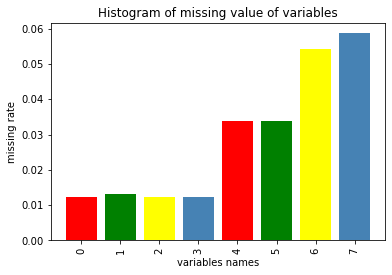

In [363]:
num_cols=['WIP_QTY','NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
missData(df_train)

In [364]:
#df_train['Finish']=np.where(df_train['TOOLG_ID_NEXT'].isnull(), 1, 0).astype(str)
#df_train['WEEKDAY']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()
 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120018 entries, 0 to 120017
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MFG_DATE     120018 non-null  int64  
 1   TOOLG_ID     120018 non-null  object 
 2   WIP_QTY      120018 non-null  float64
 3   NO_HOLD_QTY  120018 non-null  float64
 4   MOVE_QTY     120018 non-null  float64
 5   M            118540 non-null  float64
 6   U            118442 non-null  float64
 7   PT           120018 non-null  float64
 8   UP_TIME      118540 non-null  float64
 9   EQP_UTIL     118540 non-null  float64
 10  TC           115972 non-null  float64
 11  CS           115972 non-null  float64
 12  AI           113521 non-null  float64
 13  C_AI         112975 non-null  float64
dtypes: float64(12), int64(1), object(1)
memory usage: 12.8+ MB


In [365]:
#df_traindf_trainpd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()

In [366]:

df_train.head()

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
0,20200122,CI_STI,1672.0,1500.0,3371.0,5.0,0.475904,4910.234940,0.956914,0.989448,0.382283,0.354976,159.375000,0.836586
1,20200122,DGM_AM_350,377.0,324.0,2294.0,10.0,0.707514,4017.560694,0.839097,0.979897,0.264591,0.256043,101.791667,0.629749
2,20200122,DI_PSG,0.0,0.0,125.0,2.0,0.500000,16531.000000,0.986675,0.375072,0.052413,0.298198,12.250000,1.361144
3,20200122,DN_SiN,131.0,125.0,1381.0,4.0,0.782313,2056.897959,0.982981,0.779669,0.477650,0.373563,51.291667,1.101988
4,20200122,DO_SOD,13.0,12.0,706.0,2.0,1.000000,1750.037736,0.909998,0.460758,0.278303,0.183449,25.250000,3.147461


In [367]:
df_train.describe()

,MFG_DATE,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
count,1.200180e+05,120018.000000,120018.000000,120018.000000,118540.000000,118442.000000,120018.000000,118540.000000,118540.000000,115972.000000,115972.000000,113521.000000,112975.000000
mean,2.020204e+07,665.831217,584.163217,5255.925968,6.548169,0.664630,5872.975754,0.921193,0.624177,0.595742,0.561539,225.856884,2.640577
std,3.308159e+03,1518.844885,1350.837912,15090.027801,8.241060,0.296037,6802.255497,0.120564,0.296448,0.993900,0.997925,644.051553,27.075672
min,2.020012e+07,0.000000,0.000000,0.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-362.083333,-1746.889210
25%,2.020050e+07,26.000000,25.000000,235.000000,2.000000,0.430894,2059.140621,0.888972,0.392431,0.260518,0.220116,11.791667,0.816412
50%,2.020081e+07,152.000000,125.000000,834.000000,3.000000,0.671875,3804.761997,0.970585,0.693149,0.400569,0.359979,35.791667,1.542316
75%,2.020112e+07,619.000000,554.000000,2711.875000,8.000000,0.981132,6962.364087,1.000000,0.886909,0.567120,0.526168,112.208333,2.811438
max,2.021022e+07,31335.000000,29847.000000,129006.000000,64.000000,3.000000,96513.000000,1.000000,1.000000,33.466401,33.466401,5440.833333,2581.985283


In [368]:
# 5          M   1478  0.012315
# 6          U   1576  0.013131
# 8    UP_TIME   1478  0.012315
# 9   EQP_UTIL   1478  0.012315
# 10        TC   4046  0.033712
# 11        CS   4046  0.033712
# 12        AI   6497  0.054134
# 13      C_AI   7043  0.058683
#df_train['TOOLG_ID_NEXT'] = df_train['TOOLG_ID_NEXT'].fillna('NA')
# 1. 查看缺失情况
# 0.刪除null值
df_train['AI'] = df_train['AI'].fillna(df_train['AI'].mean())
df_train = df_train.dropna()
# # 1. 均值填充
# df_train['M'] = df_train['M'].fillna(df_train['M'].mean())
# df_train['U'] = df_train['U'].fillna(df_train['U'].mean())
# df_train['TC'] = df_train['TC'].fillna(df_train['TC'].mean())
# # df_train['CA'] = df_train['CA'].fillna(df_train['CA'].mean())
# df_train['CS'] = df_train['CS'].fillna(df_train['CS'].mean())
# # df_train['AI'] = df_train['AI'].fillna(df_train['AI'].mean())
# df_train['C_AI'] = df_train['C_AI'].fillna(df_train['C_AI'].mean())

# # 2.中位数填充

# 5          M   1478  0.012315
# 6          U   1576  0.013131
# 8    UP_TIME   1478  0.012315
# 9   EQP_UTIL   1478  0.012315
# 10        TC   4046  0.033712
# 11        CS   4046  0.033712
# 12        AI   6497  0.054134
# 13      C_AI   7043  0.058683
# cols=['M','U','UP_TIME','EQP_UTIL','TC','CS','C_AI']
# for col in cols:
#     df_train[col] = df_train[col].fillna(df_train[col].median())
# df_train['UP_TIME'] = df_train['UP_TIME'].fillna(df_train['UP_TIME'].median())
# df_train['EQP_UTIL'] = df_train['EQP_UTIL'].fillna(df_train['EQP_UTIL'].median())

# # 3.众数填充
# from sklearn.impute import SimpleImputer

# # imputer = Imputer(missing_values ="NaN",strategy = "most_frequent",axis = 0)
# # # imp_mean = SimpleImputer(missing_values = np.nan, strategy="most_frequent",copy=True)
# # # df_train_mean = imp_mean.fit_transform(df_train[:'CS'])
# # # df_train_mean
# # df_train['CS']=imputer.transform(df_train['CS'].reshape(-1,1))
# # imputer = SimpleImputer(missing_values ="nan",strategy = "mean")
# # df_train['CS']=imputer.fit_transform(df_train['CS'].values.reshape(-1,1))[:0]
# imp = SimpleImputer(strategy="most_frequent")
# imp.fit_transform(df_train)

print(df_train.describe())
print(df_train.info())
# strategy參數：可為"mean"(平均數[預設])、"median"(中位數)、"most_frequent"(眾數[可用於填充文字])、"constant"(常數[可用於填充文字])
# 若使用"constant"(常數)進行填補，則需再指定fill_value參數為何值
# fill_value = 0：使用0進行填補
# copy: 預設為True:創建特徵矩陣的副本 ; 設為False時，會將缺失值直接填補到原本的特徵矩陣中去
# X_missing

           MFG_DATE        WIP_QTY    NO_HOLD_QTY       MOVE_QTY  \
count  1.085980e+05  108598.000000  108598.000000  108598.000000   
mean   2.020204e+07     733.056944     643.897668    5635.953284   
std    3.312451e+03    1580.246726    1405.950742   15757.893965   
min    2.020012e+07       0.000000       0.000000       0.600000   
25%    2.020050e+07      50.000000      40.000000     299.000000   
50%    2.020081e+07     200.000000     170.000000     909.000000   
75%    2.020112e+07     721.000000     642.000000    2843.000000   
max    2.021022e+07   31335.000000   29847.000000  129006.000000   

                   M              U             PT        UP_TIME  \
count  108598.000000  108598.000000  108598.000000  108598.000000   
mean        6.952246       0.648095    5961.265449       0.919168   
std         8.455798       0.294285    6649.364058       0.118686   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.410435    222

In [369]:

# 1. 查看缺失情况
print(df_train.isnull().sum())
# print(df_test.isnull().sum())
#df_train.dropna() # 刪除null值
#df2_test = df2_test.dropna()# 刪除null值


MFG_DATE       0
TOOLG_ID       0
WIP_QTY        0
NO_HOLD_QTY    0
MOVE_QTY       0
M              0
U              0
PT             0
UP_TIME        0
EQP_UTIL       0
TC             0
CS             0
AI             0
C_AI           0
dtype: int64


In [370]:
#df_train[['WIP_QTY2']] = df_train['MOVE_QTY']+df_train['WIP_QTY']
# df_train[['ToolPrefix', 'ToolSub']] = df_train['TOOLG_ID'].str.split('_', 1, expand=True)
# df_train[['ToolPrefix_NEXT', 'ToolSub_NEXT']] = df_train['TOOLG_ID_NEXT'].str.split('_', 1, expand=True)

In [371]:
df_train = df_train.drop(columns=['MFG_DATE','AI']) #'TOOLG_ID',,'TOOLG_ID_NEXT'

In [372]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108598 entries, 0 to 120017
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TOOLG_ID     108598 non-null  object 
 1   WIP_QTY      108598 non-null  float64
 2   NO_HOLD_QTY  108598 non-null  float64
 3   MOVE_QTY     108598 non-null  float64
 4   M            108598 non-null  float64
 5   U            108598 non-null  float64
 6   PT           108598 non-null  float64
 7   UP_TIME      108598 non-null  float64
 8   EQP_UTIL     108598 non-null  float64
 9   TC           108598 non-null  float64
 10  CS           108598 non-null  float64
 11  C_AI         108598 non-null  float64
dtypes: float64(11), object(1)
memory usage: 10.8+ MB


In [373]:
#trainModel(df_train,save_model)


In [374]:
#TestModel(df_train,save_model)

In [375]:
# newdf = pd.DataFrame(np.repeat(df.values,3,axis=0))
# newdf.columns = df.columns
# print(newdf)


In [376]:
# 'CI_STI', 'DGM_AM_350', 'DI_PSG', 'DN_SiN', 'DO_SOD', 'DS_Logic',
#        'DT_BP_G/F', 'DT_O3', 'EA_AsherM', 'EC_1C', 'EC_DK_2F', 'EC_DK1',
#        'EC_Flex45_1C', 'EG_LAM_G2', 'EG_PolyEB_CIS', 'EG_PolyEB2',
#        'EH_OxEB', 'EK_1G', 'EK_aC', 'CI_ILD', 'CI_IMD', 'DA_BM', 'DB_Pre',
#        'DB_TiN', 'DGA_BM_350', 'DI_HDP', 'DK_300', 'DK_550', 'DK_SiN',
#        'DM_TiN(ASFD)', 'DR_LampA', 'DT_STI_TD', 'DW_WSi', 'EA_RWK',
#        'EB_Asher', 'EC_DK2', 'EC_Flex_38', 'EC_Flex45_F6X', 'EK_aC(JX)',
#        'EK_C/F', 'EK_RG', 'EU_Jin_Cu', 'EU_V_Cu', 'EW_3S', 'FAFS_Annl',
#        'FD_BS', 'FD_DO', 'FL_NiPt', 'FN_HTO_DK', 'IBH_HiCur', 'IBS_As(H)',
#        'ID_HiEnrg', 'MA_Al_175', 'MP_Cu', 'MR_Cu_TD', 'MS_MOCVD',
#        'MT_Ti/TiN', 'EC_LDD_Logic', 'EC_Shin_DK40', 'EC_TH_63',
#        'EC_Via_20', 'EC_Via_30', 'EC_Via_40', 'EG_Gate_232', 'EG_STI_G5',
#        'EH_CP', 'EH_LDD_2N', 'EK_1G_6X', 'EM_AL_Cln', 'EM_AL_FDY',
#        'EM_MX_W/O', 'EM_SP55_TM', 'EW_1G', 'EW_BL', 'EW_CP_72',
#        'EW_RG_63', 'PE_ChaEsr', 'PG_UVcure', 'PH_Immersion', 'QC_ET',
#        'QE_ThkMea', 'QH_XRF', 'QP_Defect', 'QS_SEM', 'RI_AM', 'SC_M.Jet',
#        'WAT_TSA', 'WDD_160_G1', 'WDD_160_G2', 'WDS_160_G2', 'WE_HV40',
#        'WK_BsEtch', 'WK_Cu', 'WM_PosCln', 'WN_ContactCln', 'FD_Tel',
#        'FE_Anneal', 'FG_GOX', 'FH_HT(L)', 'FJ_TD', 'FK_ZAC', 'FL_LT',
#        'FM_ALD', 'FM_ALD_SPT', 'FM_SiN(F)', 'FO_TiO', 'FT_119',
#        'FX_PadOxi_B', 'IBS_HiCur', 'IBV_HiCur', 'MT_TiN', 'PK_DUVKrF',
#        'PU_C/F', 'PU_I-Line', 'CU_Cu', 'DA_AM', 'DB_Ti/SFD', 'DB_Ti/TiN',
#        'DC_DCT', 'DC_WCVD', 'DD_BD_Cu', 'DGA_AM_230_LTO', 'DGA_AM_350',
#        'DGA_AM_400', 'DM_SFD_480', 'DP_SiN', 'DS_FDY', 'DS_HDP', 'DT_BP',
#        'DT_STI', 'EC_3S', 'EC_DK_1G', 'EC_Flex', 'CI_ILD_Eba',
#        'CI_STI_Eba', 'CM_W_Eba', 'CM_WCMP', 'CN_N2_Cu', 'DB_Ti',
#        'DD_BLOK_Cu', 'DM_SFD_650', 'EA_C/F', 'EC_LDD_Dram', 'EC_LDD_NXP',
#        'EC_SAC', 'EC_TH_CIS', 'EG_LAM_Poly', 'EH_PV', 'EH_SR', 'EK_1F_68',
#        'EK_1G_SDRM', 'EK_RG_SDRM', 'PW_PIX', 'QA_ADI', 'QA_AEI', 'QA_Cu',
#        'QC_CMP', 'QGK_2365', 'QX_Overly', 'QY_D.PC', 'RD_RTO', 'SC_C/F',
#        'WC_Crown', 'WD_130', 'WE_Crown', 'WO_SiO2', 'WQ_CeO2', 'WW_Poly',
#        'XE_C/F', 'EL_Light_2B', 'EM_AL_Depo', 'EM_MX', 'EM_W/O',
#        'EU_TU_Cu', 'EV_BV_AM', 'EV_BV_BM', 'EW_1GBL', 'EW_2S_G5', 'EW_CP',
#        'EW_SP(G5)', 'FD_B-Poly', 'FD_TD', 'FE_DK', 'FJ_MLD_OX',
#        'FK_LAZO(I)', 'FN_HTO', 'FN_SiN(DRAM)', 'FP_NDPoly', 'FQ_PIQ',
#        'MA_Alps', 'MB_Co(H)', 'MB_Co_350', 'MB_PC30', 'MR_Cu', 'PB_BARC',
#        'PT_Marker', 'QC_C/F', 'QC_TF', 'QPK_PUMA', 'QW_Cu', 'QW_SEM-ET',
#        'RAM_RTA', 'RDA_RTO', 'RE_EPI_ND', 'RI_BM', 'RN_RTN_5P/2N',
#        'WA_PreCln', 'WAT Out', 'WAT_TEST', 'WF_DK28', 'WF_LiEtch',
#        'WH_CIS', 'WH_EKC', 'WJ_LiEtch', 'WM_PreCln', 'WN_NiPt',
#        'WU_W-RMV', 'WW_HF', 'EC_Flex_45', 'EC_TH_45', 'EC_Via(S55)',
#        'EG_C/F', 'EG_LAM_G1', 'EG_LDD', 'EG_PolyEB', 'EG_SiN EB',
#        'EG_STI_232', 'EG_STI_DPS', 'EH_LDD_SP', 'EH_PI', 'EK_1G05_68',
#        'EL_Light', 'EM_AL_AG', 'EN_1F', 'EU_U_Cu', 'EW_4F', 'EW_RG_45',
#        'WN_Co-RMV', 'WO_NXP', 'WT_Cu', 'WW_NH4OH', 'WY_DK', 'XE_Cu',
#        'XE_Sorter', 'XW_Sorter', 'EW_SP(G2)', 'FC_PadOxi', 'FD_Ge-Poly',
#        'FH_HT', 'FH_HT_LCD', 'FI_WHoxid', 'FK_LAHO', 'FK_LAZO(F)',
#        'FL_Cu', 'FM_SiN(A)', 'FN_H(F)', 'FN_SiN(A)', 'FN_SiN(F)',
#        'FT_148', 'FT_TEOS(F)', 'IA_MidCur', 'MA_Al', 'MB_Co_250',
#        'MS_SIP', 'MW_W', 'OTHERS', 'PH_DUVArF', 'PR_Relacs', 'PW_C/F',
#        'QA_C/F', 'QC_Cu', 'QF_Wet', 'QG_Defect', 'QU_Mfilm', 'QW_C/F',
#        'QW_SEM-PH', 'QZ_Defect', 'RAA_RTA', 'RAA_Spike', 'RAM_Anneal',
#        'RN_RTN_1G', 'RS_DK', 'RS_SPA', 'WB_LiEtch', 'WC_SiO2',
#        'WE_PreCln', 'WH_DSP', 'WL_Resist', 'EC_Flex45_F7X', 'EM_W/I',
#        'RS_TD', 'WDD_SP55', 'MS_NiPt', 'QY_Defect', 'RE_EPI',
#        'FT_TEOS(TD)', 'DR_NiPt', 'DD_BD_TD', 'WK_NiPt', 'EW_3SCP',
#        'EK_1F_99', 'EC_SCCM_SiNEB', 'EW_2S_DPS', 'DC_WCVD_Cu',
#        'EC_Flex(S90)', 'EC_Con', 'RAA_DK', 'EC_SADP_DK28',
#        'FI_Whoxid(TD)', 'EK_BL20', 'DK_Li filter', 'FM_ALD(TD)',
#        'EC_HV40', 'CP TEST', 'WT Out', 'RS_S55', 'DI_TD', 'DL_TD',
#        'WM_SW', 'QD_AFM', 'EK_a-C_S', 'WR_PD_B(NPW)', 'EC_HMO',
#        'QV_CVTest', 'QP_PUMA', 'DK_Li Pi', 'EW_RG', 'EA_TD', 'EC_HARC',
#        'EK_1S_TD', 'D63FE01A', 'WR_PD_A(NPW)', 'FN_NPW', 'CI_C/F',
#        'FD_TD(T92)', 'WH_C/F', 'WH_TD', 'FD_TD(K59)', 'WG_Si', 'MS_Ta2O5',
#        'QG_2365', 'DC_400', 'EG_LAM_G3', 'PR_1B', 'FH_H88', 'EW_DK28',
#        'DI_HDP_HV80', 'DI_HDP_FSG', 'WF_Certas'

In [377]:
# WT Out
#df_train_orign.loc[df_train_orign['TOOLG_ID']=='WT Out'].iloc[0].count()
# df_train_orign.loc[df_train_orign['TOOLG_ID']=='PR_Relacs'].shape[0]
   

In [378]:
df_train_orign

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
0,20200122,CI_STI,1672.0,1500.0,3371.0,5.0,0.475904,4910.234940,0.956914,0.989448,0.382283,0.354976,159.375000,0.836586
1,20200122,DGM_AM_350,377.0,324.0,2294.0,10.0,0.707514,4017.560694,0.839097,0.979897,0.264591,0.256043,101.791667,0.629749
2,20200122,DI_PSG,0.0,0.0,125.0,2.0,0.500000,16531.000000,0.986675,0.375072,0.052413,0.298198,12.250000,1.361144
3,20200122,DN_SiN,131.0,125.0,1381.0,4.0,0.782313,2056.897959,0.982981,0.779669,0.477650,0.373563,51.291667,1.101988
4,20200122,DO_SOD,13.0,12.0,706.0,2.0,1.000000,1750.037736,0.909998,0.460758,0.278303,0.183449,25.250000,3.147461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120013,20210225,MS_MOCVD,8.0,6.0,363.0,7.0,0.439232,5021.179104,0.632350,0.625828,0.524524,0.522686,11.208333,3.648754
120014,20210225,MS_SIP,590.0,584.0,5554.0,43.0,0.528306,4330.552448,0.829726,0.917537,0.405158,0.369477,210.916667,0.693594
120015,20210225,MW_W,113.0,62.0,698.0,6.0,0.945887,1813.207792,0.772282,0.315648,0.436300,0.157383,29.583333,2.284976
120016,20210225,OTHERS,2256.0,1290.0,1066.0,3.0,0.006944,30.812500,0.666667,0.007022,4.954711,4.954711,51.875000,2.632390


In [379]:
# df_train_tool = df_train.loc[df_train['TOOLG_ID']=='EC_Flex_38']
# df_train_tool= df_train_tool.sort_values('WIP_QTY')
# df_train_tool.head()
# aa= df_train_tool['MOVE_QTY'].rolling(5).apply(lambda x: pd.Series(x).autocorr())
# aa

In [380]:
toolgCorr=[]
#df_train_orign.groupby('TOOLG_ID').size()[toolg]
for toolg in df_train_orign.TOOLG_ID.unique() :
#for toolg in ['PK_DUVKrF'] :
    df_train_orign_tool = df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg]
    df_train_tool = df_train.loc[df_train['TOOLG_ID']==toolg]
    # print(toolg,df_train_orign_tool.shape[0],df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0].shape[0])

    # print(df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0]['WIP_QTY'])
    # print(df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0]['MOVE_QTY'])
    # print(df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0].shape[0])
    # print(df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']) )
    
     
    # if  df_train_tool.shape[0]>100 and  (df_train_orign_tool['NO_HOLD_QTY'].corr(df_train_orign_tool['MOVE_QTY']) < 0.7 ) and  (df_train_orign_tool['NO_HOLD_QTY'].corr(df_train_orign_tool['MOVE_QTY']) > 0.5 ):
    if  df_train_tool.shape[0]>100 and  (df_train_orign_tool['NO_HOLD_QTY'].corr(df_train_orign_tool['MOVE_QTY']) < 0.3 ) and  (df_train_orign_tool['NO_HOLD_QTY'].corr(df_train_orign_tool['MOVE_QTY']) > 0.2 ):
   #if  df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']) > 0.7:
        print(toolg)
        # print('WIP_QTY ',df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0]['WIP_QTY'])
        # print('MOVE_QTY ' , df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0]['MOVE_QTY'])
        # print('COUNT ',df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0].count())
        # print('corr ' ,df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']) )
        # print(toolg,df_train_orign_tool.count())
        toolgCorr.append([toolg ,df_train_orign_tool['NO_HOLD_QTY'].corr(df_train_orign_tool['MOVE_QTY'])  ])
    # print(toolg ,' corr : ',df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']))
toolgCorr =np.asarray(toolgCorr) 
# toolgCorr[:,1]
 


DA_BM
DI_HDP
DK_300
EA_RWK
MP_Cu
EC_Via_20
EH_LDD_2N
WDD_160_G1
WDD_160_G2
FH_HT(L)
PK_DUVKrF
PU_I-Line
QA_ADI
QGK_2365
QX_Overly
RD_RTO
XE_C/F
EL_Light_2B
EM_MX
MB_PC30
PB_BARC
QPK_PUMA
RAM_RTA
WH_CIS
EG_SiN EB
EU_U_Cu
EW_4F
WT_Cu
FN_SiN(F)
MB_Co_250
QG_Defect
RAA_RTA
RAM_Anneal
WB_LiEtch
EW_2S_DPS
WH_C/F
DC_400
PR_1B


,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,C_AI


In [381]:
# toolgCorr = toolgCorr[(toolgCorr[:,0]=='PK_DUVKrF')]
#xy_dat[((xy_dat[:,0] > min) & (xy_dat[:,0] < max))]

In [382]:
df_train

,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,C_AI
0,CI_STI,1672.0,1500.0,3371.0,5.0,0.475904,4910.234940,0.956914,0.989448,0.382283,0.354976,0.836586
1,DGM_AM_350,377.0,324.0,2294.0,10.0,0.707514,4017.560694,0.839097,0.979897,0.264591,0.256043,0.629749
2,DI_PSG,0.0,0.0,125.0,2.0,0.500000,16531.000000,0.986675,0.375072,0.052413,0.298198,1.361144
3,DN_SiN,131.0,125.0,1381.0,4.0,0.782313,2056.897959,0.982981,0.779669,0.477650,0.373563,1.101988
4,DO_SOD,13.0,12.0,706.0,2.0,1.000000,1750.037736,0.909998,0.460758,0.278303,0.183449,3.147461
...,...,...,...,...,...,...,...,...,...,...,...,...
120013,MS_MOCVD,8.0,6.0,363.0,7.0,0.439232,5021.179104,0.632350,0.625828,0.524524,0.522686,3.648754
120014,MS_SIP,590.0,584.0,5554.0,43.0,0.528306,4330.552448,0.829726,0.917537,0.405158,0.369477,0.693594
120015,MW_W,113.0,62.0,698.0,6.0,0.945887,1813.207792,0.772282,0.315648,0.436300,0.157383,2.284976
120016,OTHERS,2256.0,1290.0,1066.0,3.0,0.006944,30.812500,0.666667,0.007022,4.954711,4.954711,2.632390


In [383]:
# for t in toolgCorr:
#     toolg = t[0]
#     df_train.loc[df_train['TOOLG_ID']==toolg]

# 觀察 散佈圖

,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,C_AI
count,227.000000,227.000000,227.000000,227.0,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000
mean,104.022026,92.242291,1697.920705,2.0,0.852881,1564.499730,0.959097,0.593174,0.454194,0.437732,1.006113
std,82.513525,79.580862,466.399106,0.0,0.051216,216.353392,0.090449,0.140740,0.324856,0.281408,0.296326
min,1.000000,0.000000,722.000000,2.0,0.723404,1151.505376,0.500000,0.274225,0.280046,0.252810,0.474533
25%,51.000000,47.500000,1374.000000,2.0,0.816870,1455.930343,0.951043,0.502747,0.349533,0.347865,0.804539
50%,80.000000,75.000000,1654.000000,2.0,0.850427,1532.722222,1.000000,0.579029,0.384674,0.387164,0.956621
75%,129.000000,123.000000,2006.000000,2.0,0.892665,1621.010369,1.000000,0.665749,0.490580,0.446335,1.141512
max,548.000000,548.000000,3527.000000,2.0,0.971591,3484.664122,1.000000,1.000000,4.907175,4.298830,2.260056


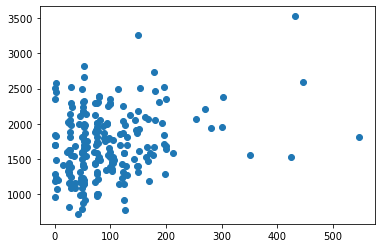

In [384]:
toolgCorr = toolgCorr[(toolgCorr[:,0]=='PK_DUVKrF')]
#toolgCorr
plt.scatter(x=df_train_orign_toolg['NO_HOLD_QTY'], y=df_train_orign_toolg['MOVE_QTY'])
df_train_orign_toolg.describe()

In [385]:
# df_train_orign.TOOLG_ID.unique()
#keyTool=['PW_C/F']
# for toolg in df_train_orign.TOOLG_ID.unique() :

# for toolg in toolgCorr[:,0]:
 
# nrows =  math.ceil(toolgCorr.shape[0]/4)
# fig, axes = plt.subplots(nrows,4,figsize=(20,5*nrows))
# idex=0
 
# for axesrow in axes:
#      for i in range(4):
#         # print(axesrow[i])
#         #t = toolgCorr[i][0]
#         if idex >= toolgCorr.shape[0]:
#             break
#         toolg = toolgCorr[idex][0]
#         df_train_orign_toolg = df_train.loc[df_train['TOOLG_ID']==toolg]

#         axesrow[i].scatter(x=df_train_orign_toolg['NO_HOLD_QTY'], y=df_train_orign_toolg['MOVE_QTY'])
         
        
#         axesrow[i].grid()
#         axesrow[i].set_ylabel('MOVE_QTY', fontsize=12)
#         # ax.set_xlabel('WIP_QTY', fontsize=12)
#         axesrow[i].set_xlabel('NO_HOLD scatter', fontsize=12)
        
#         axesrow[i].set_title(f'Group: {toolg}', fontsize=12)
#         idex+=1
         
# plt.show()



In [386]:
df_train.head()

,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,C_AI
0,CI_STI,1672.0,1500.0,3371.0,5.0,0.475904,4910.234940,0.956914,0.989448,0.382283,0.354976,0.836586
1,DGM_AM_350,377.0,324.0,2294.0,10.0,0.707514,4017.560694,0.839097,0.979897,0.264591,0.256043,0.629749
2,DI_PSG,0.0,0.0,125.0,2.0,0.500000,16531.000000,0.986675,0.375072,0.052413,0.298198,1.361144
3,DN_SiN,131.0,125.0,1381.0,4.0,0.782313,2056.897959,0.982981,0.779669,0.477650,0.373563,1.101988
4,DO_SOD,13.0,12.0,706.0,2.0,1.000000,1750.037736,0.909998,0.460758,0.278303,0.183449,3.147461


In [387]:
#df_train_orign_toolg.head()

In [388]:
#df_train_orign_toolg.head()

# 訓練機台模型

In [401]:
# for t in toolgCorr:  
#     toolg=t[0]
#     df_train_orign_toolg = df_train.loc[df_train['TOOLG_ID']==toolg]   
#     save_model2 = getSavePath(df_train_orign_toolg['TOOLG_ID'].iloc[0],save_model)
#     #print(df_train_orign_toolg['TOOLG_ID'].iloc[0])
#     cleanString = re.sub('\W+','', df_train_orign_toolg['TOOLG_ID'].iloc[0] )
#     print(cleanString)
    # path = save_model
    # path = save_model.replace(save_model.split('/', 2)[len( save_model.split('/', 2))-1],cleanString+save_model.spll6≥÷it('/', 2)[len(     save_model.split('/', 2))-1])
    # print(path)
for t in toolgCorr:     
    toolg=t[0]
    df_train_orign_toolg = df_train.loc[df_train['TOOLG_ID']==toolg]
    #trainModel(toolg,df_train_orign_toolg,save_model)
    trainModelXG(toolg,df_train_orign_toolg,save_modelxg)

	eval-rmse:2859.00708	eval-mae:990.67065	train-logloss:-1490085.75000	train-rmse:0.01460	train-mae:0.01285
[858]	eval-logloss:-1480207.50000	eval-rmse:2859.00708	eval-mae:990.67065	train-logloss:-1490085.75000	train-rmse:0.01461	train-mae:0.01285
[859]	eval-logloss:-1480207.50000	eval-rmse:2859.00708	eval-mae:990.67065	train-logloss:-1490085.75000	train-rmse:0.01461	train-mae:0.01285
[860]	eval-logloss:-1480207.50000	eval-rmse:2859.00708	eval-mae:990.67078	train-logloss:-1490085.75000	train-rmse:0.01461	train-mae:0.01285
[861]	eval-logloss:-1480207.50000	eval-rmse:2859.00708	eval-mae:990.67078	train-logloss:-1490085.75000	train-rmse:0.01461	train-mae:0.01285
[862]	eval-logloss:-1480207.50000	eval-rmse:2859.00708	eval-mae:990.67078	train-logloss:-1490085.75000	train-rmse:0.01461	train-mae:0.01286
[863]	eval-logloss:-1480207.50000	eval-rmse:2859.00708	eval-mae:990.67078	train-logloss:-1490085.75000	train-rmse:0.01461	train-mae:0.01286
[864]	eval-logloss:-1480207.50000	eval-rmse:2859.0070

In [390]:
# df_testing

# 測試 臨界值

In [391]:
df_train.loc[df_train['TOOLG_ID']==toolg].describe()

,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,C_AI
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,15649.438903,14153.817955,40379.463840,30.710723,0.069952,2991.323249,0.950456,0.973200,0.505878,0.297117,0.269249
std,3268.166719,3199.797732,3007.540615,2.598290,0.058100,64.123117,0.033644,0.013019,0.148899,0.086718,0.930544
min,3163.000000,2805.000000,8038.000000,2.000000,0.033333,2821.530355,0.598291,0.920092,0.230723,0.228487,-18.039123
25%,13475.000000,12024.000000,38973.000000,30.000000,0.063549,2949.116780,0.936987,0.965570,0.451458,0.260931,0.219441
50%,15328.000000,13833.000000,40498.000000,31.000000,0.065769,2988.247734,0.954241,0.974747,0.479877,0.276570,0.268364
75%,17406.000000,15948.000000,41968.000000,32.000000,0.068811,3027.918790,0.968883,0.982608,0.508988,0.297060,0.358968
max,31335.000000,29847.000000,45816.000000,32.000000,1.101804,3353.320665,1.000000,1.000000,1.733301,1.003306,1.352526


In [392]:
#df_testing

# 執行模型預測

17474.0 10
./GX/PK_DUVKrFtraining_model2.model
        NO_HOLD_QTY  MOVE_QTY             M            U           PT  \
count   1000.000000    1000.0  1.000000e+03  1000.000000  1000.000000   
mean   22469.000000   39188.0  3.071072e+01     0.069952  2991.323249   
std     2888.194361       0.0  7.108983e-15     0.000000     0.000000   
min    17474.000000   39188.0  3.071072e+01     0.069952  2991.323249   
25%    19971.500000   39188.0  3.071072e+01     0.069952  2991.323249   
50%    22469.000000   39188.0  3.071072e+01     0.069952  2991.323249   
75%    24966.500000   39188.0  3.071072e+01     0.069952  2991.323249   
max    27464.000000   39188.0  3.071072e+01     0.069952  2991.323249   

            UP_TIME      EQP_UTIL           TC            CS          C_AI  
count  1.000000e+03  1.000000e+03  1000.000000  1.000000e+03  1.000000e+03  
mean   9.504564e-01  9.731997e-01     0.505878  2.971171e-01  2.692492e-01  
std    3.332336e-16  2.221557e-16     0.000000  1.110779e-16  1.

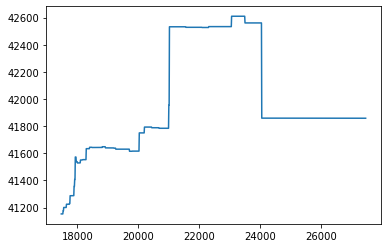

In [402]:
#cols=df_train.columns
cols=['M','U','PT','UP_TIME','EQP_UTIL','TC','CS','C_AI']
#for toolg in toolgCorr[:,0]:     
# for toolg in toolgCorr[:,0]:  
# 

for t in toolgCorr:
    toolg=t[0]
    # df_test_orign_toolg = df_train.loc[df_train['TOOLG_ID']==toolg]
    # df_testing =df_test_orign_toolg
    df_testing= df_train.loc[df_train['TOOLG_ID']==toolg]
    df_testing[cols] = df_testing[cols].mean()
    df_testing =df_testing[0:1]
    # max_wip = df_testing['NO_HOLD_QTY'].max()* .75
    max_wip = np.percentile(df_testing['NO_HOLD_QTY'], 50) # return 50th percentile, e.g median.
    tick = (df_testing['NO_HOLD_QTY'].max() - df_testing['NO_HOLD_QTY'].min()) /400
    if max_wip <=0 :
        
        max_wip=100
    if tick <10 :
        tick = 10
    print(max_wip,tick)
    #print(" max_wip" ,max_wip)
    
    
    
    # cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
    # df_testing[cols] = df_train[cols].mean()
    # df_testing.head()
    # df_train_orign.info()
    # print(df_testing.columns)
    # print(df_testing.head)
    # print(df_testing.mean())
    # df = pd.DataFrame(['FE_Anneal',584.163217,750.0,6.548169,0.66463,5872.975754,0.921801,0.625027,0.59574,0.561539,225.856884,	2.640577,'Wednesday','FE_Anneal'], columns = df_train.columns)
    #df = pd.DataFrame( df_testing[0:1], columns = df_testing.columns)
    # df.loc[0] = df_testing[0:1]
    # df_testing_template= ['FE_Anneal',584.163217,750.0,6.548169,0.66463,5872.975754,0.921801,0.625027,0.59574,0.561539,225.856884,	2.640577,'Wednesday','FE_Anneal']#df_testing[0:1]

 
    # testModel(df_train_orign_toolg,save_model)
    df = pd.DataFrame(columns = df_testing.columns)
   
    for i in range(1000):
        # #pd.concat([ df_testing ,df_testing_template]) 
        # df.append(df_testing_template,ignore_index=True,sort=False)
        # #print(df_testing.shape)
        # #print(df_testing_template)
        # df.loc[i]=df_testing[0:1]
        # df.append(pd.Series(df_testing[0:1].values.tolist(), index=newDF.columns[:len(df_testing[0:1].values.tolist())]), ignore_index=True)
        
        df_testing['NO_HOLD_QTY']=max_wip+ tick*i
        #print(i,df_testing.head())
        # n =pd.Series(df_testing[0:1].values.tolist())
        df = df.append(df_testing,ignore_index=True)
        
    #print(df.shape,df.head())        
    # TestModel(df,save_model)
    TestModelXG(df,save_modelxg)
       

In [394]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TOOLG_ID     1000 non-null   object 
 1   WIP_QTY      1000 non-null   float64
 2   NO_HOLD_QTY  1000 non-null   float64
 3   MOVE_QTY     1000 non-null   float64
 4   M            1000 non-null   float64
 5   U            1000 non-null   float64
 6   PT           1000 non-null   float64
 7   UP_TIME      1000 non-null   float64
 8   EQP_UTIL     1000 non-null   float64
 9   TC           1000 non-null   float64
 10  CS           1000 non-null   float64
 11  C_AI         1000 non-null   float64
 12  predict      1000 non-null   float32
dtypes: float32(1), float64(11), object(1)
memory usage: 97.8+ KB


In [395]:
# df_train.loc[df_train['TOOLG_ID']=='PK_DUVKrF']  
# df1=readDataFromFile('./MG-1M.csv')
# df1.columns

# sweetviz

In [396]:


# import sweetviz as sv
# pairwise_analysis='on' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
# df1=readDataFromFile('./MG-1M.csv')
# # 1. 查看缺失情况
# df1.fillna(value=0, inplace=True)
# # nullseries = df1.isnull().sum()
# # print(nullseries[nullseries > 0])
# # df1['TECH-PROD_ID'] = df1['TECH']+df1['PROD_ID']
# # df1['LAYER-STAGE'] = df1['LAYER']+df1['STAGE']
# # df1['OPER_NAME-LAYER-STAGE']= df1['OPER_NAME']+df1['LAYER']+df1['STAGE']
# # df1['ROUTE_ID-OPER_NAME']= df1['ROUTE_ID']+df1['OPER_NAME'] 
# # df1['ROUTE_ID-OPER_NAME-LAYER-STAGE']= df1['ROUTE_ID']+df1['OPER_NAME']+df1['LAYER']+df1['STAGE']
# # df1['ROUTE_ID-LAYER'] = df1['ROUTE_ID']+df1['LAYER']
# # df1['ROUTE_ID-STAGE'] = df1['ROUTE_ID']+df1['STAGE']

# feature_config = sv.FeatureConfig()
# #                                    force_cat=['TECH','PROD_ID','ROUTE_ID','OPER_NAME','LAYER','STAGE','LOT_PRTY','LOT_TYPE','LAYER','STAGE','TECH-PROD_ID'	 
# # ,'LAYER-STAGE'	 
# # ,'OPER_NAME-LAYER-STAGE' 
# # ,'ROUTE_ID-OPER_NAME' 
# # ,'ROUTE_ID-OPER_NAME-LAYER-STAGE' 
# # ,'ROUTE_ID-LAYER' 
# # ,'ROUTE_ID-STAGE' ])


# report_train = sv.analyze([df1, 'train'],
#                                 target_feat='MOVE_QTY', # Categorical特徵
#                                 feat_cfg=feature_config,
#                                 pairwise_analysis  = pairwise_analysis) 


# report_train.show_html(filepath='Basic_train_reportMG1M.html' ) # 儲存為html的格式

# # # compare_subsets_report = sv.compare_intra(df_train,
# # #                                         df_train['Finish']==1, # 給條件區分
# # #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
# # #                                         target_feat='MOVE_QTY',
# # #                                         )

# # # compare_subsets_report.show_html(filepath='./sweetvizHTML/Compare_male_female_report.html')




In [397]:

 
# pairwise_analysis='on' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
# df1=readDataFromFile('./MG-2M.csv')
# # # 1. 查看缺失情况
# df1.fillna(value=0, inplace=True)
# # nullseries = df1.isnull().sum()
# # print(nullseries[nullseries > 0])

# # df1['TECH-PROD_ID'] = df1['TECH']+df1['PROD_ID']
# # df1['LAYER-STAGE'] = df1['LAYER']+df1['STAGE']
# # df1['OPER_NAME-LAYER-STAGE']= df1['OPER_NAME']+df1['LAYER']+df1['STAGE']
# # df1['ROUTE_ID-OPER_NAME']= df1['ROUTE_ID']+df1['OPER_NAME'] 
# # df1['ROUTE_ID-OPER_NAME-LAYER-STAGE']= df1['ROUTE_ID']+df1['OPER_NAME']+df1['LAYER']+df1['STAGE']
# # df1['ROUTE_ID-LAYER'] = df1['ROUTE_ID']+df1['LAYER']
# # df1['ROUTE_ID-STAGE'] = df1['ROUTE_ID']+df1['STAGE']

# feature_config = sv.FeatureConfig()
# #                                    force_cat=['TECH','PROD_ID','ROUTE_ID','OPER_NAME','LAYER','STAGE','LOT_PRTY','LOT_TYPE','LAYER','STAGE','TECH-PROD_ID'	 
# # ,'LAYER-STAGE'	 
# # ,'OPER_NAME-LAYER-STAGE' 
# # ,'ROUTE_ID-OPER_NAME' 
# # ,'ROUTE_ID-OPER_NAME-LAYER-STAGE' 
# # ,'ROUTE_ID-LAYER' 
# # ,'ROUTE_ID-STAGE' ])


# report_train = sv.analyze([df1, 'train'],
#                                 target_feat='MOVE_QTY', # Categorical特徵
#                                 feat_cfg=feature_config,
#                                 pairwise_analysis  = pairwise_analysis) 


# report_train.show_html(filepath='Basic_train_reportMG2M.html' ) # 儲存為html的格式

# # # compare_subsets_report = sv.compare_intra(df_train,
# # #                                         df_train['Finish']==1, # 給條件區分
# # #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
# # #                                         target_feat='MOVE_QTY',
# # #                                         )

# # # compare_subsets_report.show_html(filepath='./sweetvizHTML/Compare_male_female_report.html')




In [398]:
# df1

In [399]:
# plt.plot([1,2,3,4], [1,4,9,16])